# Práctica 1: Clustering con K-Means

---

Iria Agulló Gómez

Sara Porto Álvarez

## Instalar paquetes necesarios

Se instala el paquete kneed para poder calcular el método del codo.

In [131]:
!pip install kneed

## Imports

Se importan una serie de librerías para el correcto funcionamiento del programa.

In [132]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

## Semilla

Se establece una semilla para garantizar la reproducibilidad del código.

In [133]:
np.random.seed(42)

## Clase K-Means hecha de cero

La clase **KMeansScratch** tiene una serie de atributos, que son:
* `n_clusters`: Número de clusters que queremos obtener.
* `max_iter`: Número máximo de iteraciones a realizar para encontrar los centroides finales.
* `init_method`: Método empleado para inicializar los clusters
  * `random`: aleatoriamente entre los límites del dataset
  * `dataset`: aleatoriamente de entre los puntos del dataset

---
La función **`getCentroids`** servirá para obtener los centroides a la hora de ejecutar el programa.

---
La función **`fit`** se encarga del entrenamiento del modelo K-Means. Primero, llama a `initialize_centroids` para inicializar los centroides. Dependiendo del método de inicialización de clusters, los centroides se inicializarán de una manera u otra, tal y como se especificó previamente. En caso de que el método de inicialización no sea correcto, se lanzará un error.



A continuación, en el `fit`, se hace el bucle de entrenamiento durante max_iter iteraciones. Primero se llama a `assign_clusters`para asignar a cada una de las instancias el centroide más cercano a dicha instancia (teniendo en cuenta la distancia euclídea entre dos puntos, calculada en el método `euclidean_distance`). En caso de que haya una instancia que tenga dos centroides a la misma distancia, se escogerá el centroide con menor número de instancias.


Después, se actualizan los centroides; buscando unos nuevos centroides con la función `update_centroids`. Así, los nuevos centroides se corresponderán con la media de los puntos asignados a cada cluster en la iteración anterior.


En el caso de que los centroides no cambien, se detiene el entrenamiento (y no se llegan a evaluar las max_iter). Si no, se actualizan los centroides para la próxima iteración.

---
Por último, se devuelven los puntos asociados a cada cluster.

In [134]:
### CLASE KMEANS from scratch ###
class KMeansScratch:

    ## Atributos
    def __init__(self, n_clusters=4, max_iter=100, init_method='random'):
        '''
        n_clusters: Número de clusters
        max_iter: Número máximo de iteraciones
        init_method: Método de inicialización de los centroides (random, dataset)
        centroids: Coordenadas de los centroides
        '''
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.init_method = init_method
        self.centroids = None

    ## Obtener los centroides
    def getCentroids(self):
        return ("Centroides: \n" + str(self.centroids))

    ## Inicialización de los centroides
    def initialize_centroids(self, X):
        '''
        X: Datos
        '''

        # Centroides inicializados aleatoiramente dentro de los límites de los datos
        if self.init_method == 'random':
            x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
            y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
            self.centroids = np.column_stack((
                np.random.uniform(x_min, x_max, self.n_clusters),
                np.random.uniform(y_min, y_max, self.n_clusters)
            ))

        # Centroides inicializados con instancias aleatorias del dataset
        elif self.init_method == 'dataset':
            indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.centroids = X[indices]

        # Inicialización no válida
        else:
            raise ValueError("Método de inicialización no válido")

    ## Cálculo de la distancia euclidiana entre dos puntos
    def euclidean_distance(self, a, b) -> np.ndarray:
        '''
        a, b: Puntos
        '''
        return np.sqrt(np.sum((a - b) ** 2, axis=1))

    ## Asignación de instancias a los clusters
    def assign_clusters(self, X) -> np.ndarray:
        '''
        X: Datos
        '''

        # Distancia de cada instancia a los centroides
        distances = np.array([self.euclidean_distance(X, centroid) for centroid in self.centroids])
        labels = np.argmin(distances, axis=0) # Cluster más cercano a cada instancia

        # EQUILIBRIO de tamaño en caso de EMPATE
        cluster_sizes = np.bincount(labels, minlength=self.n_clusters)
        for i in range(X.shape[0]):
            min_dist_clusters = np.where(distances[:, i] == np.min(distances[:, i]))[0]
            if len(min_dist_clusters) > 1:
                smallest_cluster = min(min_dist_clusters, key=lambda c: cluster_sizes[c])
                labels[i] = smallest_cluster
                cluster_sizes[smallest_cluster] += 1
                cluster_sizes[min_dist_clusters[min_dist_clusters != smallest_cluster]] -= 1

        return labels

    ## Actualización de los centroides
    def update_centroids(self, X, labels) -> np.ndarray:
        '''
        X: Datos
        labels: Clusters asignados a las instancias
        '''
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))

        for i in range(self.n_clusters):
            if np.any(labels == i):
                new_centroids[i] = X[labels == i].mean(axis=0)
            else:
                new_centroids[i] = self.centroids[i]

        return new_centroids

    ## Entrenamiento del modelo
    def fit(self, X):
        '''
        X: Datos
        '''

        self.initialize_centroids(X)  # inicialización centroides

        # Bucle de entrenamiento (teniendo en cuenta max_iter)
        for _ in range(self.max_iter):
            labels = self.assign_clusters(X)  # asignación de instancias a clusters
            new_centroids = self.update_centroids(X, labels) # actualización de centroides

            # Centroides no cambian --> DETIENE el entrenamiento
            if np.allclose(self.centroids, new_centroids):
                break

            # Actualización de centroides
            self.centroids = new_centroids

        return labels

## Funciones para encontrar el K (nº de clusters) óptimo

Se definen un par de funciones para encontrar el número óptimo de clusters del dataset con el que se trabaje.

### Con coeficiente de Silhouette

Se utiliza el coeficiente de Silhouette para determinar (dentro de un rango definido por max_k). Cuanto mayor sea el coeficiente asociado al k evaluado, mejor será k. Para mayor claridad, se muestra una gráfica con los k evaluados, sus coeficientes de silhouette y se marca el k óptimo.

Se devuelve el k óptimo para guardarlo y utilizarlo al entrenar el modelo posteriormente.

In [135]:
def find_optimal_clusters_silhouette(X, max_k=10):
    '''
    X: Datos
    max_k: Número máximo de clusters
    '''
    # Lista para almacenar Coeficientes de Silhouette
    silhouette_scores = []
    k_values = range(2, max_k)

    # Evaluar distintos k
    for k in k_values:
        kmeans = KMeansScratch(n_clusters=k, max_iter=100, init_method='random')
        labels = kmeans.fit(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

    # Obtener el k con el mejor Silhouette Score
    optimal_k = k_values[np.argmax(silhouette_scores)]

    # Graficar datos
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Óptimo k={optimal_k}')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Silhouette')
    plt.show()

    return optimal_k

### Con el método del codo

Se utiliza el método del codo para determinar (dentro de un rango definido por max_k). Se almacena el SSE (error cuadrático medio) de con uno de los k a evaluar entre los puntos y sus centroides. Con ayuda de la función KneeLocator se encuentra el punto óptimo de k. De nuevo, se grafica todo ello.

Se devuelve el k óptimo para guardarlo y utilizarlo al entrenar el modelo posteriormente.

In [148]:
### FUNCIÓN PARA ENCONTRAR K ÓPTIMO - ELBOW METHOD ###
def find_optimal_clusters_elbow(X, max_k=10):
    '''
    X: Datos
    max_k: Número máximo de clusters
    '''
    # Lista para almacenar la SSE (inertia)
    sse = []
    k_values = range(2, max_k)

    # Evaluar distintos valores de k
    for k in k_values:
        kmeans = KMeansScratch(n_clusters=k, max_iter=100, init_method='random')
        labels = kmeans.fit(X)

        # Calcular SSE (suma distancias cuadráticas de los puntos a sus centroides)
        inertia = 0
        for i, centroid in enumerate(kmeans.centroids):
            inertia += np.sum((X[labels == i] - centroid) ** 2)

        sse.append(inertia)

    # Encontrar codo
    kneedle = KneeLocator(k_values, sse, curve="convex", direction="decreasing")
    optimal_k = kneedle.elbow

    # Graficar método del codo
    plt.plot(k_values, sse, 'o-')
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("SSE")
    plt.title("Método del Codo para determinar k óptimo")
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Óptimo k={optimal_k}')
    plt.legend()
    plt.show()

    return optimal_k

## Bucle principal


### Dataset

Se crea un dataset sintético para poder hacer K-means. Se muestra el dataset con un scatterplot, así como su número de instancias.

(300, 2)


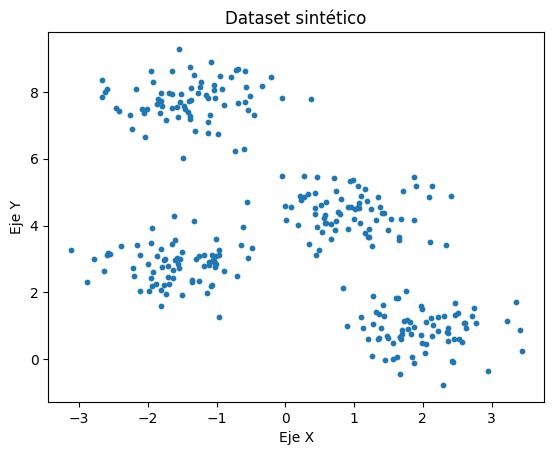

In [137]:
## DATASET
# Creación dataset
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Nº instancias
print(X.shape)

# Visualizar datos
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Dataset sintético")
plt.show()

### Encontrar número óptimo de clusters - Silhouette score


Se encuentra el número de clusers óptimo para el dataset con la función del coeficiente de Silhouette.

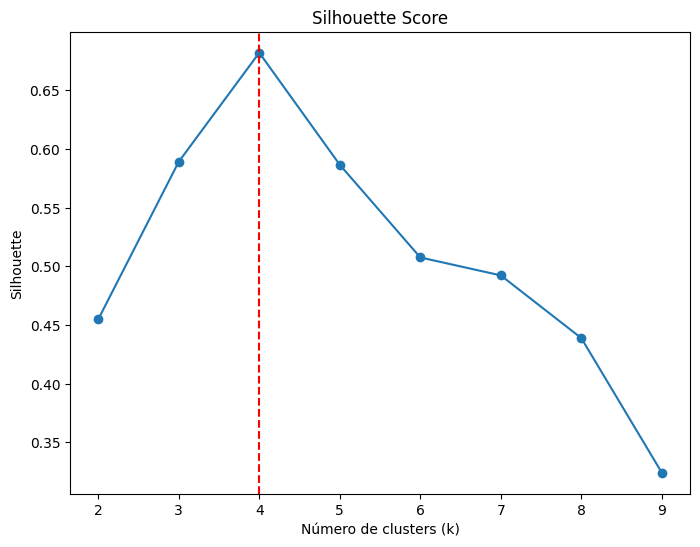

K óptimo con Silhouette Score: 4


In [138]:
## ENCONTRAR K ÓPTIMO - SILHOUETTE SCORE
optimal_k_silhouette = find_optimal_clusters_silhouette(X, max_k=10)
print(f"K óptimo con Silhouette Score: {optimal_k_silhouette}")

### Encontrar número óptimo de clusters - Elbow method


Se encuentra el número de clusers óptimo para el dataset con la función del método del codo.

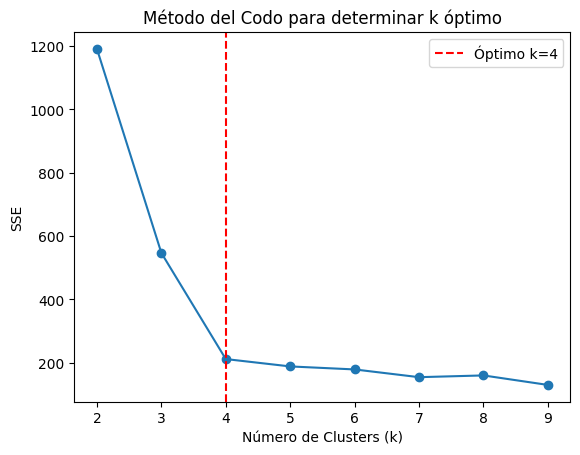

K óptimo con Elbow Method: 4


In [149]:
## ENCONTRAR K ÓPTIMO - ELBOW METHOD
optimal_k_elbow = find_optimal_clusters_elbow(X, max_k=10)
print(f"K óptimo con Elbow Method: {optimal_k_elbow}")

### K-Means inicializado 'random'

Se muestra un ejemplo de K-Means con el método de inicialización random y con el número de clusters definido por el óptimo de la función con el coeficiente de Silhouette.

Se visualizan los clusters y se devuelven los centroides finales.

Centroides: 
[[ 1.98258281  0.86771314]
 [-1.58438467  2.83081263]
 [ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]]


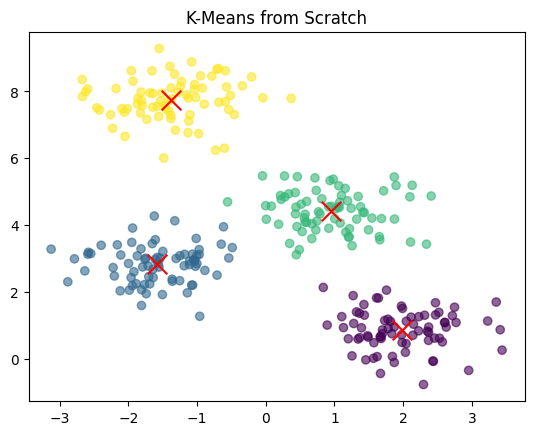

In [140]:
## KMEANS
# Modelo
kmeans = KMeansScratch(n_clusters=optimal_k_silhouette, max_iter=100, init_method='random')
labels = kmeans.fit(X)
print(kmeans.getCentroids())

# Visualización de los clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=200)
plt.title("K-Means from Scratch")
plt.show()

## K-Means inicializado 'dataset'

Se muestra un ejemplo de K-Means con el método de inicialización dataset y con el número de clusters definido por el óptimo de la función con el método del codo.

Se visualizan los clusters y se devuelven los centroides finales.

Centroides: 
[[-1.58438467  2.83081263]
 [ 1.98258281  0.86771314]
 [-1.37324398  7.75368871]
 [ 0.94973532  4.41906906]]


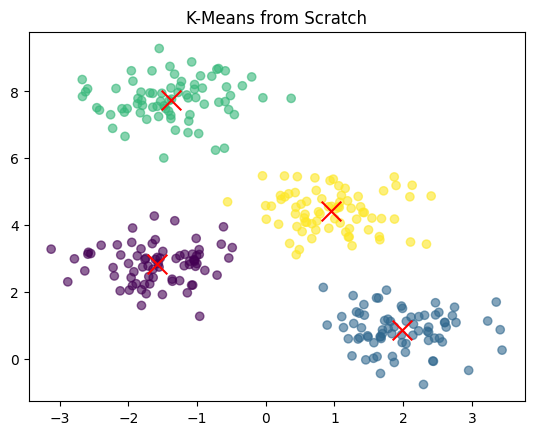

In [141]:
## KMEANS
# Modelo
kmeans = KMeansScratch(n_clusters=optimal_k_elbow, max_iter=100, init_method='dataset')
labels = kmeans.fit(X)
print(kmeans.getCentroids())

# Visualización de los clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=200)
plt.title("K-Means from Scratch")
plt.show()

## Conclusiones

Con todo, los resultados son adecuados; ya que el número óptimo de clusters es 4 (observable a simple vista, pero también definido al crear el dataset sintético). Los clusters obtenidos parecen ser correctos, así como sus centroides.

Además, los dos métodos de obtención del k óptimo, proporcionan el mismo resultado (4 clusters); y los scatterplot con los dos métodos de inicialización de centroides proporcionan resultados práctiamente en cuanto a los clusters (que a simple vista parece que coinciden en los puntos que clasifican en cada cluster) y centroides que devuelven (estos coinciden en el mismo conjunto de valores, pero están ordenados de manera diferente).